# BATSEJ OPEN FINANCE SA

BATSEJ OPEN FINANCE S.A es un negocio financiero que compra bases de datos a 
otras entidades financieras y ofrece soluciones a sus clientes de verificación de 
cuentas bancarias activas por medio de APIs, ya que estos comercios dentro de sus 
procesos necesitan esta funcionalidad.  
En un entorno donde la precisión y la eficiencia son cruciales, la capacidad de verificar 
cuentas bancarias de manera rápida y confiable se convierte en un diferenciador clave. 
Las soluciones de verificación de cuentas bancarias no solo ayudan a prevenir fraudes, 
sino que también mejoran la confianza y la satisfacción del cliente. Al automatizar este 
proceso, BATSEJ OPEN FINANCE S.A busca reducir errores humanos, acelerar las 
operaciones y proporcionar un servicio más seguro y eficiente a sus clientes.
El cobro de comisiones es una manera de evaluar el retorno de los llamados de las 
API’s, asegurando que los recursos se utilicen de manera efectiva y que las 
operaciones sean rentables.  
A continuación se detallan las condiciones contractuales para cada comercio

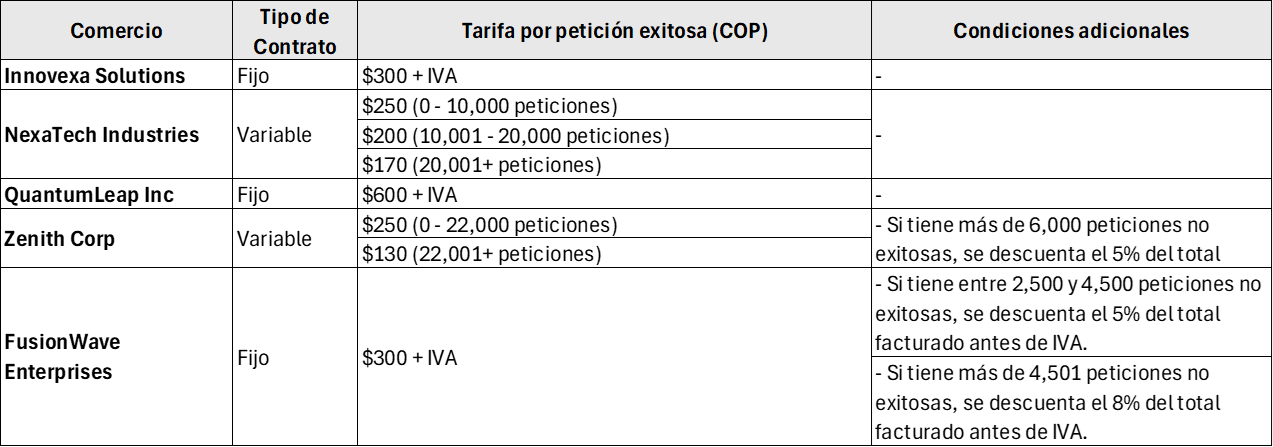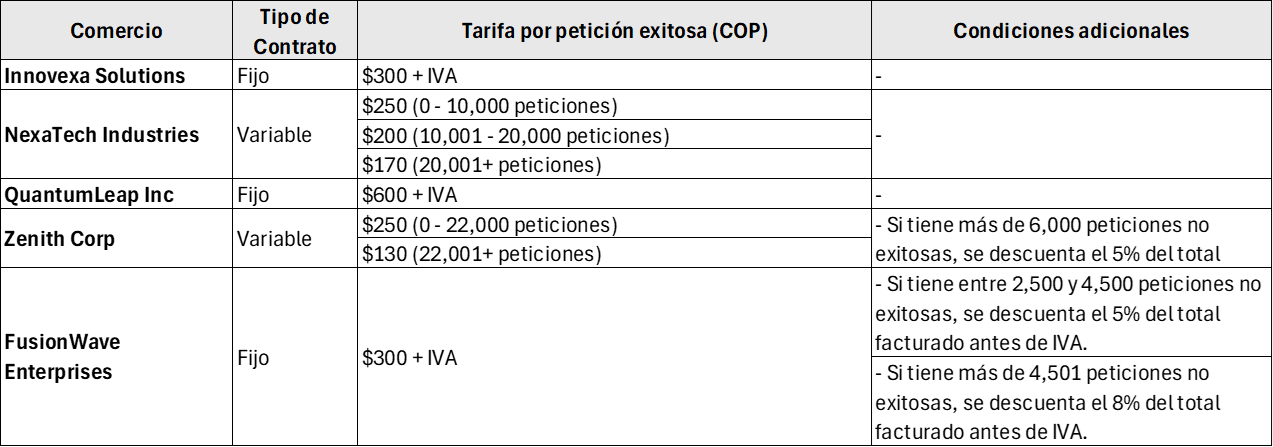

## Importar librerias

In [1]:
#Cargar librerías necesarias para las actividades
import sqlite3
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime
import os

## Leer el archivo .sqlite
La lectura se realizará usando la librería sqlite3. Al desconocer las tablas que contiene, se hará una búsqueda de los registros en cada tabla y el nombre de la misma.

In [2]:
# Obtener el nombre del usuario y definir la ruta de la base de datos en Descargas
usuario = os.getlogin()
ruta_db = fr"C:\Users\{usuario}\Downloads\database\database.sqlite"

# Conectar a la base de datos
conn = sqlite3.connect(ruta_db)

# Obtener la lista de tablas en la base de datos
query_tablas = "SELECT name FROM sqlite_master WHERE type='table';"
tablas = pd.read_sql(query_tablas, conn)

# Mostrar las tablas disponibles
print("Tablas disponibles en la base de datos:")
display(tablas)  # Muestra la tabla en formato bonito

# Leer y mostrar los datos de cada tabla
for tabla in tablas["name"]:
    print(f"\nCargando datos de la tabla: {tabla}")
    df = pd.read_sql_query(f"SELECT * FROM {tabla}", conn)
    display(df.head())  # Muestra las primeras filas de la tabla

# Cerrar la conexión
conn.close()

Tablas disponibles en la base de datos:


,name
0,apicall
1,commerce



Cargando datos de la tabla: apicall


,date_api_call,commerce_id,ask_status,is_related
0,2024-10-21 18:31:16,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
1,2024-10-13 17:12:08,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
2,2024-12-23 01:02:06,Rh2k-J1o7-zndZ-cOo8,Successful,1.0
3,2024-07-11 07:24:35,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
4,2024-06-28 11:43:52,Rh2k-J1o7-zndZ-cOo8,Successful,1.0



Cargando datos de la tabla: commerce


,commerce_id,commerce_nit,commerce_name,commerce_status,commerce_email
0,KaSn-4LHo-m6vC-I4PU,445470636,Innovexa Solutions,Inactive,innovexasolutions@microfitsof.com
1,Vj9W-c4Pm-ja0X-fC1C,452680670,NexaTech Industries,Active,nexatechindustries@gemaily.net
2,Rh2k-J1o7-zndZ-cOo8,198818316,QuantumLeap Inc.,Active,quantumleapinc.@gemaily.net
3,3VYd-4lzT-mTC3-DQN5,28960112,Zenith Corp.,Active,zenithcorp.@gemaily.net
4,GdEQ-MGb7-LXHa-y6cd,919341007,FusionWave Enterprises,Active,fusionwaveenterprises@microfitsof.com


## Análisis Exploratorio de datos
Se parte de una identificación de los campos, según lo que se puede observar en los ejemplos, luego se hace la lectura de cada tabla en un dataframe distinto.

### Campos de la tabla commerce
Se identifica que es una tabla maestra, desde la cuál se complementa la información en la tabla transaccional de las peticiones
**commerce_id**: Identificador único de comercio. Se encuentran 5 valores únicos de los Id's  
**commerce_nit**: NIT de comercio  
**commerce_name**: Nombre del comercio  
**commerce_status**: Estado del comercio (Activo / Inactivo)  
**commerce_email**: Correo relacionado del comercio

In [3]:
# Leer una tabla en un DataFrame
conn = sqlite3.connect(ruta_db)

table_commerce = pd.read_sql_query("SELECT * FROM commerce", conn)
#table_apicall["is_related"] = table_apicall["is_related"].astype(bool)

table_commerce.head()

,commerce_id,commerce_nit,commerce_name,commerce_status,commerce_email
0,KaSn-4LHo-m6vC-I4PU,445470636,Innovexa Solutions,Inactive,innovexasolutions@microfitsof.com
1,Vj9W-c4Pm-ja0X-fC1C,452680670,NexaTech Industries,Active,nexatechindustries@gemaily.net
2,Rh2k-J1o7-zndZ-cOo8,198818316,QuantumLeap Inc.,Active,quantumleapinc.@gemaily.net
3,3VYd-4lzT-mTC3-DQN5,28960112,Zenith Corp.,Active,zenithcorp.@gemaily.net
4,GdEQ-MGb7-LXHa-y6cd,919341007,FusionWave Enterprises,Active,fusionwaveenterprises@microfitsof.com


### Campos de la tabla apicall
Se realiza el cruce entre con la tabla maestra utilizando el id del comercio para trabajar con nombres detallados y filtrar solo aquellos que se encuentran activos en el momento de ejecutar el Script.  
También se mencionan los campos de la tabla apicall  
**date_api_call**: Fecha en la que se hizo el llamado desde la API  
**commerce_id**: Identificador único del comercio. Se encuentran 5 valores únicos de los Id's  
**ask_status**: Respuesta del servicio (Successfull/No exitosa)  
**is_related**: Es un booleano

In [4]:
# Leer una tabla en un DataFrame
conn = sqlite3.connect(ruta_db)

sql="""
SELECT 
t1.date_api_call,  --Selecciona la fecha del llamado a la API de la tabla apicall
t2.commerce_name,  -- Seleccionar el nombre del comercio
t1.ask_status   --Selecciona el estado de la transacción
FROM apicall as t1  --Selecciona la tabla apicall
INNER JOIN commerce as t2 on t1.commerce_id=t2.commerce_id  --Cruza por el id del comercio con la tabla commerce
WHERE t2.commerce_status="Active"   -- Selecciona los comercios Activos
"""

df = pd.read_sql_query(sql, conn)

# Cambia el tipo de datos de la fecha de String a datetime
df['date_api_call'] = pd.to_datetime(df['date_api_call'], errors='coerce')

df.head()

,date_api_call,commerce_name,ask_status
0,2024-01-01 00:00:29,NexaTech Industries,Successful
1,2024-01-01 00:01:01,NexaTech Industries,Successful
2,2024-01-01 00:01:12,NexaTech Industries,Successful
3,2024-01-01 00:01:29,NexaTech Industries,Unsuccessful
4,2024-01-01 00:03:19,NexaTech Industries,Successful


In [5]:
# Extraer el año y el mes para evaluar la cantidad de registros por cada mes
df['año'] = df['date_api_call'].dt.year
df['mes'] = df['date_api_call'].dt.month

# Agrupar por año y mes y contar los registros
resultados = df.groupby(['año', 'mes']).size().reset_index(name='conteo')

# Mostrar el resultado
print(resultados)

     año  mes  conteo
0   2024    1  101411
1   2024    2   94974
2   2024    3  101534
3   2024    4   98489
4   2024    5  101831
5   2024    6   98255
6   2024    7  101842
7   2024    8  101589
8   2024    9   98590
9   2024   10  101664
10  2024   11   98393
11  2024   12  101328


In [6]:
#Voy a verificar la cantidad de registros y el % que representan para los campos, nombre del comercio y respuesta de la solicitud
columnas = ["commerce_name", "ask_status"]

# Obtiene el total general de registros
total_registros = len(df)

# Itera sobre las columnas seleccionadas y obtener los valores únicos con sus conteos y porcentajes
for columna in columnas:
    print(f"\nValores únicos y sus conteos en la columna: {columna}")
    
    # Obtiene el conteo de valores únicos
    conteos = df[columna].value_counts()
    
    # Calcula el porcentaje de registros con respecto al total
    porcentajes = (conteos / total_registros) * 100
    
    # Mostrar los resultados incluyendo el porcentaje
    for valor, cantidad in conteos.items():
        print(f"{valor}: {cantidad} registros ({porcentajes[valor]:.1f}%)")


Valores únicos y sus conteos en la columna: commerce_name
Zenith Corp.: 300512 registros (25.0%)
NexaTech Industries: 299955 registros (25.0%)
QuantumLeap Inc.: 299781 registros (25.0%)
FusionWave Enterprises: 299652 registros (25.0%)

Valores únicos y sus conteos en la columna: ask_status
Successful: 960459 registros (80.0%)
Unsuccessful: 239441 registros (20.0%)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199900 entries, 0 to 1199899
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date_api_call  1199900 non-null  datetime64[ns]
 1   commerce_name  1199900 non-null  object        
 2   ask_status     1199900 non-null  object        
 3   año            1199900 non-null  int32         
 4   mes            1199900 non-null  int32         
dtypes: datetime64[ns](1), int32(2), object(2)
memory usage: 36.6+ MB


In [8]:
# Tabla de contingencia commerce_id / ask_status
# Permite observar por comercio, el estado de las transacciones ejecutadas en general
pd.crosstab(index=df["ask_status"], columns=df["commerce_name"],margins=True)

commerce_name,FusionWave Enterprises,NexaTech Industries,QuantumLeap Inc.,Zenith Corp.,All
ask_status,,,,,
Successful,239507,240385,239976,240591,960459
Unsuccessful,60145,59570,59805,59921,239441
All,299652,299955,299781,300512,1199900


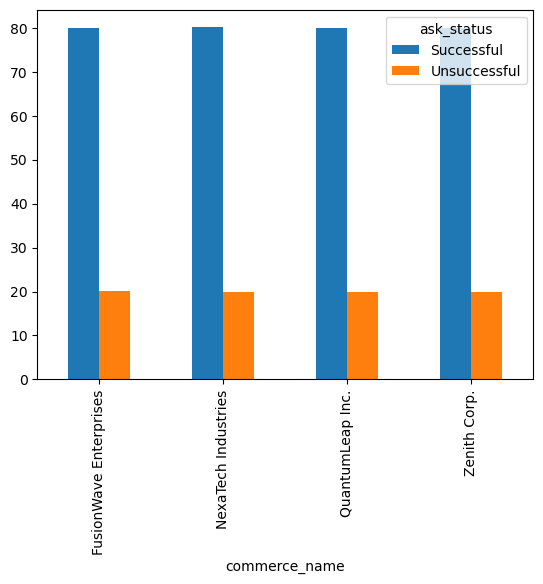

In [9]:
# Tabla de contingencia commerce_id / ask_status
# Grafica los resultados vistos anteriormente en porcentaje
plot= pd.crosstab(index=df["commerce_name"], columns=df["ask_status"]).apply(lambda r:r/r.sum() * 100, axis=1).plot(kind='bar')

## Lógica de las comisiones

In [10]:
# Funciones para cada tipo de comercio

def calcular_innovexa(casos_exitosos, *args):
    # Solo necesita casos_exitosos
    return casos_exitosos * 300  # $300 por cada caso exitoso

def calcular_nexatech(total_casos, casos_exitosos, *args):
    # Necesita total_casos y casos_exitosos
    if total_casos <= 10000:
        return casos_exitosos * 250  # $250 por cada caso exitoso hasta 10,000
    elif total_casos <= 20000:
        return casos_exitosos * 200  # $200 por cada caso exitoso entre 10,001 y 20,000
    else:
        return casos_exitosos * 170  # $170 por cada caso exitoso de más de 20,000

def calcular_quantumleap(casos_exitosos, *args):
    # Solo necesita casos_exitosos
    return casos_exitosos * 600  # $600 por cada caso exitoso

def calcular_zenith(total_casos, casos_exitosos, casos_no_exitosos):
    # Necesita total_casos, casos_exitosos y casos_no_exitosos
    if total_casos <= 22000:
        cobro = casos_exitosos * 250  # $250 por cada caso exitoso hasta 22,000 peticiones realizadas
    else:
        cobro = casos_exitosos * 130  # $130 por cada caso exitoso de más de 22,000 peticiones realizadas

    # Si hay más de 6,000 peticiones no exitosas, aplicar un descuento del 5%
    if casos_no_exitosos > 6000:
        cobro *= 0.95  # Aplicar un 5% de descuento
    
    return cobro

def calcular_fusionwave(casos_exitosos, casos_no_exitosos, *args):
    # Necesita casos_exitosos y casos_no_exitosos
    cobro = casos_exitosos * 300  # $300 por cada caso exitoso
    
    # Descuentos según el número de peticiones no exitosas
    if casos_no_exitosos >= 2500 and casos_no_exitosos <= 4500:
        cobro *= 0.95  # 5% de descuento
    elif casos_no_exitosos > 4500:
        cobro *= 0.92  # 8% de descuento
    
    return cobro

# Diccionario que mapea cada comercio con su función de cálculo
reglas_comercio = {
    "Innovexa Solutions": calcular_innovexa,
    "NexaTech Industries": calcular_nexatech,
    "QuantumLeap Inc.": calcular_quantumleap,
    "Zenith Corp.": calcular_zenith,
    "FusionWave Enterprises": calcular_fusionwave
}

# Función para calcular el cobro
def calcular_cobro(total_casos, casos_exitosos, casos_no_exitosos, comercio):
    if comercio in reglas_comercio:
        # Llamar a la función correspondiente según el comercio
        return reglas_comercio[comercio](total_casos, casos_exitosos, casos_no_exitosos)
    else:
        # Si el comercio no existe, retornar 0 o algún valor por defecto
        print(f"Comercio {comercio} no reconocido")
        return 0

## Valor total por comercio
Definida la función para cada comercio, con esto calculo el valor que debe pagar utilizando un primer for para iterar por cada comercio y luego un segundo for para iterar por cada mes del año y guardo todos los calculos en un diccionario llamado resultados

In [11]:
# Crear un diccionario para guardar los resultados
resultados={}

# Iterar sobre los comercios únicos
for comercio in df['commerce_name'].unique():
    # Filtrar el DataFrame por comercio
    df_comercio = df[df['commerce_name'] == comercio]
    
    # Crear un diccionario para almacenar los casos por año-mes
    comercio_resultados = {}
    
    # Agrupar por año, mes y ask_status, y calcular el total de las peticiones y los peticiones exitosos
    for (año, mes), grupo in df_comercio.groupby(['año', 'mes']):
        total_casos = len(grupo)
        casos_exitosos = (grupo['ask_status'] == 'Successful').sum()  # Contar las peticiones exitosas
        casos_no_exitosos = (grupo['ask_status'] != 'Successful').sum()  # Contar los peticiones no exitosos
        porcentaje_exitosos = (casos_exitosos / total_casos) * 100  # Calcular el porcentaje de peticiones exitosas
        
        # Calcular el cobro según las peticiones totales, exitosas y no exitosas
        cobro = calcular_cobro(total_casos,casos_exitosos, casos_no_exitosos, comercio)
        
        # Guardar el resultado en el diccionario
        comercio_resultados[(año, mes)] = {
            'total_casos': total_casos,
            'casos_exitosos': casos_exitosos,
            'casos_no_exitosos': casos_no_exitosos,
            'porcentaje_exitosos': porcentaje_exitosos,
            'cobro': cobro
        }
    
    # Guardar los resultados del comercio
    resultados[comercio] = comercio_resultados

Desde acá, guardo con el formato que nos están pidiendo los resultados obtenidos anteriormente.

In [12]:
# Crear una lista vacía para almacenar los resultados
resultados_lista = []

# Iterar sobre los resultados para agregar la información a la lista
for comercio, resultado in resultados.items():
    for (año, mes), datos in resultado.items():
        año_mes = f"{año}-{str(mes).zfill(2)}"  #Agrego el campo año mes con el formato yyyy-mm
        iva=0.19  #Agrego el valor del IVA
        
        # Crear un diccionario para cada fila de resultados
        resultado_fila = {
            'Fecha-Mes': año_mes,
            'Nombre': comercio,
            'Total Casos': datos['total_casos'],
            'Casos Exitosos': datos['casos_exitosos'],
            'Casos No Exitosos': datos['casos_no_exitosos'],
            'Porcentaje Exitosos': datos['porcentaje_exitosos'],
            'Valor_comision': datos['cobro'],
            'Valor_iva': iva,
            'Valor_Total': datos['cobro'] * (iva+1)
        }
        # Agregar la fila a la lista de resultados
        resultados_lista.append(resultado_fila)

## Validación resultados
Se conviertes la lista en un dataframe y se visualizan los resultados según lo solicitado.

In [13]:
df_resultados = pd.DataFrame(resultados_lista)
df_resultados.head(100)

,Fecha-Mes,Nombre,Total Casos,Casos Exitosos,Casos No Exitosos,Porcentaje Exitosos,Valor_comision,Valor_iva,Valor_Total
0,2024-01,NexaTech Industries,25155,20157,4998,80.131187,3426690.0,0.19,4077761.10
1,2024-02,NexaTech Industries,23505,18768,4737,79.846841,3190560.0,0.19,3796766.40
2,2024-03,NexaTech Industries,25563,20518,5045,80.264445,3488060.0,0.19,4150791.40
3,2024-04,NexaTech Industries,24827,19861,4966,79.997583,3376370.0,0.19,4017880.30
4,2024-05,NexaTech Industries,25445,20352,5093,79.984280,3459840.0,0.19,4117209.60
5,2024-06,NexaTech Industries,24618,19705,4913,80.043058,3349850.0,0.19,3986321.50
6,2024-07,NexaTech Industries,25416,20387,5029,80.213251,3465790.0,0.19,4124290.10
7,2024-08,NexaTech Industries,25388,20358,5030,80.187490,3460860.0,0.19,4118423.40
8,2024-09,NexaTech Industries,24745,19907,4838,80.448575,3384190.0,0.19,4027186.10
9,2024-10,NexaTech Industries,25577,20440,5137,79.915549,3474800.0,0.19,4135012.00


## Ajuste entregable
Se cruza con el dataframe de los comercios para a partir del nombre, traer el correo y el nit de la organización. Se ajustan los nombres de los campos y se organiza según el esquema solicitado. En esta parte también se realiza el filtro para solo mostrar lo de Julio y Agosto, aunque se propone que traiga siempre la información del mes anterior y se vaya consolidando.
Finalmente se ajusta una ruta y se carga el dataframe resultando en un archivo de excel que siempre estará en la carpeta de descargas del usuario.

In [14]:
# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados_lista)

# Agregar el nit y el correo del comercio del dataframe "table_commerce"
df_resultados=pd.merge(df_resultados,table_commerce[['commerce_name', 'commerce_email','commerce_nit']], how="inner", left_on=["Nombre"],right_on=["commerce_name"])

# Renombrar las columnas, según el nombre solicitado
df_resultados=df_resultados.rename(columns={"commerce_email":"Correo","commerce_nit":"Nit"})

# Ordenar los campos según el esquema solicitado
df_resultados=df_resultados[["Fecha-Mes","Nombre","Nit","Valor_comision","Valor_iva","Valor_Total","Correo"]]

df_resultados=df_resultados[df_resultados["Fecha-Mes"].isin(["2024-07", "2024-08"])]

file_path=fr"C:\Users\{usuario}\Downloads\BATSEJ OPEN FINANCE SA.xlsx"

df_resultados.to_excel(file_path,index=False)

# Mostrar el los resultados para el mes de julio y agosto
df_resultados.head(100)

,Fecha-Mes,Nombre,Nit,Valor_comision,Valor_iva,Valor_Total,Correo
6,2024-07,NexaTech Industries,452680670,3465790.0,0.19,4124290.10,nexatechindustries@gemaily.net
7,2024-08,NexaTech Industries,452680670,3460860.0,0.19,4118423.40,nexatechindustries@gemaily.net
18,2024-07,QuantumLeap Inc.,198818316,15279000.0,0.19,18182010.00,quantumleapinc.@gemaily.net
19,2024-08,QuantumLeap Inc.,198818316,15222000.0,0.19,18114180.00,quantumleapinc.@gemaily.net
30,2024-07,Zenith Corp.,28960112,2651220.0,0.19,3154951.80,zenithcorp.@gemaily.net
31,2024-08,Zenith Corp.,28960112,2653820.0,0.19,3158045.80,zenithcorp.@gemaily.net
42,2024-07,FusionWave Enterprises,919341007,7043796.0,0.19,8382117.24,fusionwaveenterprises@microfitsof.com
43,2024-08,FusionWave Enterprises,919341007,7004604.0,0.19,8335478.76,fusionwaveenterprises@microfitsof.com


## Destinatarios del correo
Se asignan los destinatarios en un diccionario. Pueden ser n destinatarios según se requiera.
Se configura el correo en general y se adjunta el archivo de excel que se tenía en las descargas.

In [15]:
import win32com.client as win32

asunto ='Resultados Facturación por comercio Julio y Agosto 2024'

# Diccionario de destinatarios
destinatarios = {
    "Lewis Andres Puello Perez": "lpuello@bancolombia.com.co"
}

# Convertir los correos en una cadena separada por "; "
destinatarios_str = "; ".join(destinatarios.values())

contenido_html = f"""
    <html>
        <body>
            <p>Hola,</p>
            <p>Adjunto envío el consolidado de la facturación actualizada por comercio.</p>
            <p>Saludos cordiales.</p>
        </body>
    </html>
    """
ruta_adjunto = fr"C:\Users\{usuario}\Downloads\BATSEJ OPEN FINANCE SA.xlsx"
    
def envio_correo(destinatarios_str,asunto,contenido,ruta_adjunto):
    outlook = win32.Dispatch('outlook.application')
    mail = outlook.CreateItem(0)
    mail.To = destinatarios_str
    mail.Subject = asunto
    mail.Body ='Correo enviado'
    mail.HTMLBody = contenido_html
    #se adjunta el archivo
    mail.Attachments.Add(ruta_adjunto)

    #envío
    mail.Send()

envio_correo(destinatarios_str, asunto,contenido_html,ruta_adjunto)

print(f"✅ Correo enviado")

✅ Correo enviado
